In [2]:
from tensorflow import keras
from dualpole import DualPole
from visualization import plot_mean, plot_bins, plot_rewards, render_episode
from util import load_results, load_rewards
from evaluation import train_model
from train import build_cartpole, build_dualpole, build_model_common, build_model_split

# 14 - Actor Critic

Ich habe versucht, das Notebook noch um ein paar Kommentare zu erweitern, da es eigentlich  für die Präsentation mit zusätzlichen Erklärungen gedacht war und ich aufgrund der Zeitnot zum Ende leider nicht ausführlich auf die Beobachtungen eingehen konnte. Alle verwendeten Ergebnisse finden sich zudem im Ordner `evaluations/`.

## Übersicht

1. **Actor Critic**
    - Policy Gradient
    - Actor Critic
    - Implementierung
2. **CartPole-v1**
    - Trainingsbeispiel
    - Vergleich verschiedener Modell-Architekturen
3. **DualPole**
    - Modifizierte Gym-Umgebung
    - Trainingsergebnisse und Beobachtungen
4. **Abstand erzwingen**
    - Terminieren bei Berührung
    - Reward verringern

# 1. Actor Critic

## 1.1 Policy Gradient
* Betrachte Gradienten für gesamte Trajektorie $\tau=(s_1,a_1,...,s_T,a_T)$ (globale Methode) 
* Nutzt Wahrscheinlichkeitsverteilung über actions $a$: $\pi_{\theta}(a,s)$
* Erwarteter Reward für Modellparameter $\theta$: $J(\theta)=\sum_{\tau}P(\tau,\theta)R(\tau)$
    * $R(\tau)=\sum_{t=0}^{T}\gamma^tr_t$
    * $P(\tau,\theta)=P(s_0)\Pi_{t=1}^T P(s_t | s_{t-1},a_t) \pi_\theta(a_t | s_{t-1})$
* Bestimme _Policy Gradient_ $\nabla_\theta J(\theta)$ um Modellparameter zu verbessern: 
$$  \nabla_\theta J(\theta) = \frac{1}{M} \sum_{i=1}^M \sum_{t=1}^{T_i} \nabla_\theta log \pi_\theta \left( a_t | s_{t-1}(\tau^{(i)} \right) R(\tau^{(i)}) $$

## 1.2 Actor Critic
* Nutze _value function_ $V(s)$ als _Baseline_, um zu bestimmen ob gewählte Actions einen Vorteil bringen
* _Advantage_: $A_t=R_t - V(s_t)$
* Daraus ergibt sich neuer Gradient:
$$ \nabla_\theta J(\theta) = \frac{1}{M} \sum_{i=1}^M \sum_{t=1}^{T_i} \nabla_\theta \underbrace{ log \pi_\theta \left( a_t | s_{t-1}(\tau^{(i)} \right) }_{Actor} \underbrace{ \left(R_t(\tau^{(i)}) - V(s_t^{(i)}) \right) }_{Critic} $$
* Modell lernt also zusätzlich zur policy $\pi(s)$ auch eine Schätzung von $V(s)$ 
* Mögliches Teilen der Parameter (aus VL):

![ac_types](res/actor_critic_types_small.PNG)

## 1.3 Implementierung

* Actor-Critic Implementierung aus Tensorflow Tutorial zu CartPole-v0:
https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic?hl=en

### Expected Returns $R_t$

* Anhand der unmittelbaren rewards $r_t$ wird für jeden Zeitschritt $t$ der gesamte noch folgende Return $R_t(\tau)=\sum_{k=t}^{T}\gamma^tr_k$ berechnet.

```python
def get_expected_return():
    """Compute expected returns per timestep."""

    ...

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = (returns - tf.math.reduce_mean(returns))
                    / (tf.math.reduce_std(returns) + eps)

    return returns

```

### Actor und Critic Loss 

* Das Actor-Update ergibt sich aus dem per-sample Loss für eine Trajektorie $\tau$ :
$$L_{actor} =  - \sum_{t=1}^{T} log \pi_\theta \left( a_t | s_{t-1}(\tau \right)  \left(R_t(\tau) - V(s_t) \right) $$

* $V(s_t)$ soll möglichst nah an $R(s_t)$ gebracht werden. Daraus ergibt sich $L_{critic}$:
$$ L_{critic} = \sum_{i=1}^{T} HuberLoss(R(s_t), V(s_t)) $$

```python
def compute_loss(...):
    """Computes the combined actor-critic loss."""

    # Actor
    advantage = returns - values
    action_log_probs = tf.math.log(action_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

    # Critic
    critic_loss = huber_loss(values, returns)

    return actor_loss + critic_loss
```

### Trainings-Update

* Eine Trajektorie wird anhand der aktuellen Modellparameter generiert. Anschließend wird der Actor-Critic-Updateschritt durchgeführt. 
* Da die gesamte Funktion nur Tensorflow-Operationen verwendet, kann ein Tensorflow Graph erstellt werden.

```python
@tf.function
def train_step_tf(...):
    """Runs a model training step."""
    
    # Allows automatic differentiation in tensorflow graph
    with tf.GradientTape() as tape:

        # Run the model for one episode to collect training data
        action_probs, values, rewards= run_episode(initial_state, 
                                                   model, max_steps_per_episode)
        
        ...

        # Calculate expected returns
        returns = get_expected_return(rewards, gamma)

        # Calculating loss values to update our network
        loss = compute_loss(action_probs, values, returns)

    # Compute the gradients from the loss
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Apply the gradients to the model's parameters
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
```

### Gesamtes Training

* Iteratives verbessern der Modellparameter bis Problem gelöst oder maximale Anzahl an Episoden erreicht ist.

```python
def train_model(...):
    
    # Build the environment and the model
    env, env_name = build_env()
    model, model_info = build_model(env.observation_space.shape[0], env.action_space.n)
    
    # Generate a new tensorflow graph for each model
    train_step = get_train_step(env)
    
    # Store the training history (i.e. the episode rewards)
    history = History()
    
    # Iterate the training steps until a maximum number of episodes is reached 
    for episode in range(MAX_EPISODES):
        
        # Perform the Actor-Critic update step
        episode_reward = train_step(model, optimizer, gamma, MAX_STEPS)

        # Track the performance
        history.add_reward(episode_reward)
        avg_reward = history.get_avg_reward()
        
        # Check if solved
        if avg_reward > avg_threshold:
            break
    ...
```

### Erstellen des Modells

* Modell mit gemeinsamen Gewichten für Actor und Critic (analog dazu gibt es die geteilte Variante).
* Anzahl und Größe der hidden-Layer sind variabel.

```python
def create_model_common(num_states, num_actions, hidden_layers=[128]):
    # Input ergibt sich aus der Anzahl an states
    inputs = layers.Input(shape=(num_states,), name="input")

    # Die gemeinsamen layer anhand vom Parameter hidden_layer erstellen 
    common_layers = []
    for i, hidden_units in enumerate(hidden_layers):
        previous = inputs if i == 0 else common_layers[-1]
        layer = layers.Dense(hidden_units, 
                             activation="relu", 
                             name=f"common{i}")(previous)
        common_layers.append(layer)

    # Actor- und Critic-Ausgabeschicht hinter dem letzten gemeinsamen Layer.
    actor = layers.Dense(num_actions, name="actor")(common_layers[-1])
    critic = layers.Dense(1, name="critic")(common_layers[-1])

    # Das zusammengefasste Modell mit Actor- und Critic-Output
    return keras.Model(inputs=inputs, outputs=[actor, critic])

```

# 2. CartPole-v1


![cartpole](res/cartpole.PNG)
* Erweiterung von CartPole-v0 (längere Episoden)
* State: $s=(x,\dot{x},\theta,\dot{\theta})$ 
* Actions: $a \in \{0,1\}$ ("nach links/rechts stoßen")
* Episode wird beendet, wenn...
    - das Cart außerhalb des sichtbaren Bereichs fährt: $|x| > 2.4$ 
    - der Neigungswinkel zu stark ist: $|\theta| > 12^°$
    - 500 Zeitschritte erreicht sind
* $r_t = 1$ für jeden Zeitschritt der Episode
* Gilt als gelöst, falls der durchschnittliche Reward der letzten 100 Episoden über 475 liegt
* Anfänglicher State ist zufällig (sehr nah) um $(0,0,0,0)$ verteilt

## 2.1 Training mit split10_10
* Architektur: Zwei separate Netze mit jeweils 10 Neuronen in einem hidden layer

![](res/model_split10_10_small.png)

Episode 758:   3%|▌                       | 758/30000 [01:36<1:01:55,  7.87it/s, episode_reward=500, avg100_reward=475]


INFO:tensorflow:Assets written to: presentation/CartPole-v1_04-07_12_31_46/model\assets


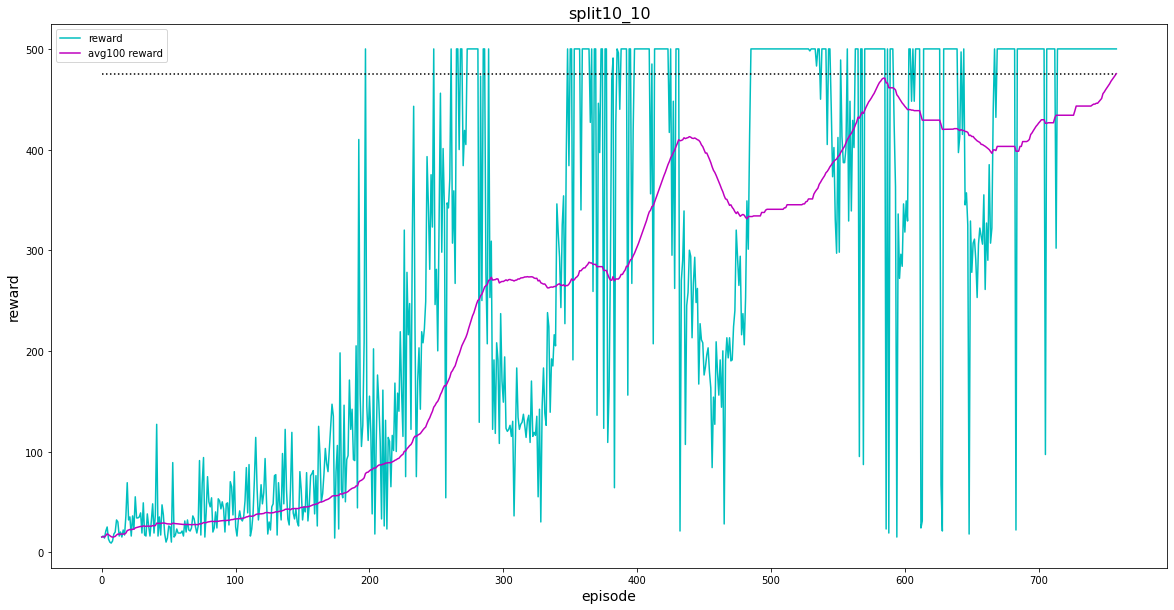

In [3]:
build_env = build_cartpole()
build_model = build_model_split(actor_layers=[10], critic_layers=[10])

env, env_name = build_env()
_, model_name = build_model(1, 1)

# train model
model, history = train_model(build_env, build_model, render_freq=200, base_dir="presentation")

# retrieve reward and average reward
rewards = history.rewards
avg_rewards = history.get_avg_rewards()

# plot reward over training
plot_rewards([rewards, avg_rewards], labels=["reward", "avg100 reward"], title=model_name, figsize=(20, 10))

#### Trainiertes Verhalten demonstrieren
* Durchläuft Episoden mit dem gerade trainierten model

In [ ]:
episodes = 1
for _ in range(episodes):
    render_episode(env, model, 500)

## 2.2 Vergleich verschiedener Modell-Architekturen

* Grundsätzlich ist CartPole-v1 gut lösbar
* Training dauert mindestens ca. 30 Sekunden
* Mehrere Modell-Architekturen wurden jeweils 15 mal trainiert
* Zum Vergleich: Durchschnitt über die Anzahl der benötigten Trainings-Episoden berechnen

### Durchschnittliche Anzahl der Trainings-Episoden
* common32 und split10_10 lösen jeweils im Durchschnitt am schnellsten
* Mehr als ein hidden layer erfordert deutlich längeres Training

In [4]:
env_name = "CartPole-v1"
model_names = ["common16", "common32", "common64", "split8_8", "split10_10", "split16_16", "common16x16", "common32x32"]
model_results = [load_results(env_name, model_name) for model_name in model_names]

plot_mean(model_names, model_results, title="Durchschnittlich benötigte Trainings-Episoden zum Lösen von CartPole-v1")

### Verhalten während des Trainings
* Verhalten des Agenten visualisiert anhand eines Beispieldurchlaufs mit Modell common32 (1 gemeinsames hidden layer mit 32 Neuronen für Actor und Critic)

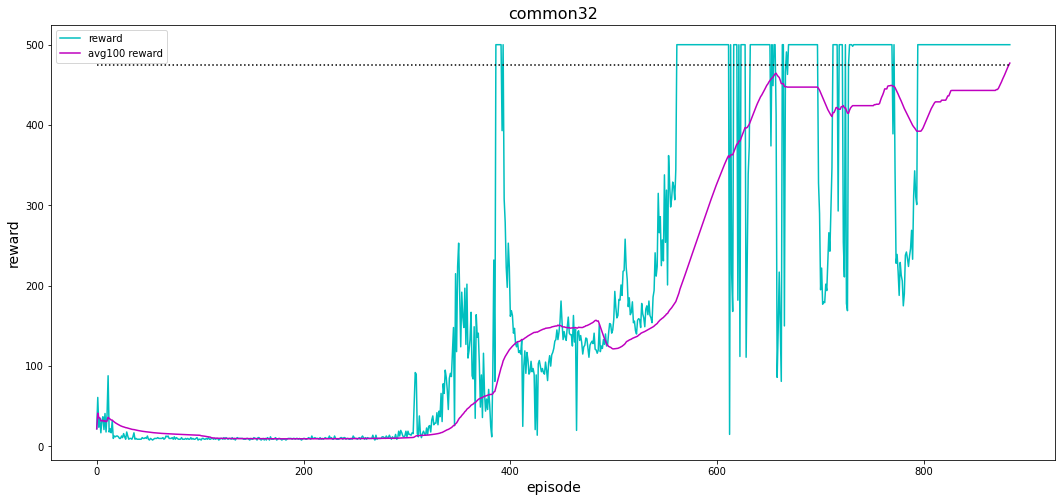

In [6]:
directory = "evaluation/CartPole-v1_common32/CartPole-v1_04-05_23_17_06" # durchschnittlich
rewards, avg_rewards = load_rewards(directory)
plot_rewards([rewards, avg_rewards], labels=["reward", "avg100 reward"], title="common32", figsize=(18,8))

#### 200 Episoden:
![](evaluation/CartPole-v1_common32/CartPole-v1_04-05_23_17_06/gifs/episode200.gif)
#### 400 Episoden:
![](evaluation/CartPole-v1_common32/CartPole-v1_04-05_23_17_06/gifs/episode400.gif)
#### 600 Episoden:
![](evaluation/CartPole-v1_common32/CartPole-v1_04-05_23_17_06/gifs/episode800.gif)
#### 883 Episoden (solved):
![](evaluation/CartPole-v1_common32/CartPole-v1_04-05_23_17_06/gifs/episode883_solved.gif)


### Varianz der Trainings-Durchläufe

* In wie vielen Episoden CartPole-v1 gelöst wird schwankt stark zwischen den Durchläufen (auch bei den zuverlässigsten Modell-Architekturen mit wenigen Neuronen)
* Histogramm über die Anzahl an benötigten Episoden der 15 Durchläufe zeigt Streuung:

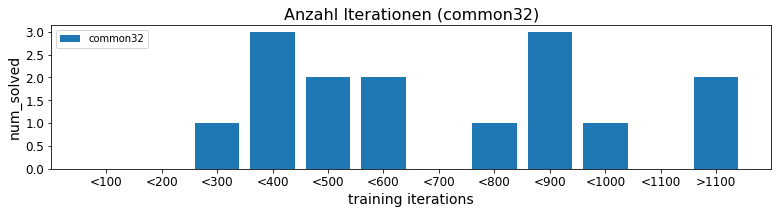

In [7]:
plot_bins(model_names[4], model_results[4], 100, 11, title="Anzahl Iterationen (split10_10)")
plot_bins(model_names[1], model_results[1], 100, 11, title="Anzahl Iterationen (common32)")

# 3. DualPole

![cartpole](res/dualpole.PNG)

## 3.1 Modifizierte Gym Umgebung
* Existierende gym-CartPole Implementierung als Ausgangspunkt 
* Zwei Carts gleichzeitig steuern
* State: $s=(x_1,\dot{x_1},\theta_1,\dot{\theta}_1,x_2,\dot{x_2},\theta_2,\dot{\theta_2})$ 
* Actions: $a \in \{0,1,2,3\}$
* Startkoordinaten: $x_1=-1$, $x_2=1$
* Episode wird beendet, wenn eins der beiden Carts crashed
* Ansonsten identische Umgebung und Abbruchbedingungen
* "Ineinanderfahren" vorerst erlaubt

## 3.2 Trainingsergebnisse und Beobachtungen

* Training dauert deutlich länger (ca. 5-10 Minuten)
* Wesentlich mehr Neuronen benötigt im Vergleich zu CartPole
* Gemeinsame Gewichte zwischen Actor und Critic sind deutlich zuverlässiger

In [8]:
env_name = "DualPole"
model_name = "common128"

base_dir = "evaluation/DualPole_common128"
runs = ["DualPole_04-06_09_51_57", "DualPole_04-06_10_08_10", "DualPole_04-06_10_30_34"]
list_of_avg_rewards = [load_rewards(f"{base_dir}/{run}")[1] for run in runs]

plot_rewards(list_of_avg_rewards, [f"Durchlauf {i+1}" for i,_ in enumerate(runs)],title="average reward (common128)", figsize=(18, 8), rgb_colors=True)

### Verhalten während des Trainings (Durchlauf 1)

#### Episode 1500:
![](evaluation/DualPole_common128/DualPole_04-06_09_51_57/gifs/episode1500.gif)
#### Episode 3000:
![](evaluation/DualPole_common128/DualPole_04-06_09_51_57/gifs/episode3000.gif)
#### Episode 4500:
![](evaluation/DualPole_common128/DualPole_04-06_09_51_57/gifs/episode4500.gif)
#### Episode 6531 (solved):
![](evaluation/DualPole_common128/DualPole_04-06_09_51_57/gifs/episode6531_solved.gif)

# 4. Abstand erzwingen

* Bisher können Carts ineinander fahren (und tun es auch)
* Ansätze das zu verhindern sind z.B.:
    * Die Episode beenden wenn die Carts sich berühren
    * Reward verringern wenn Carts zu nah aneinander sind

## 4.1 Terminieren bei Berührung

* Abstand zwischen den beiden Carts darf $0.5$ nicht unterschreiten
* Die DualPole-Umgebung terminiert die Episode wenn $x_2 - x_1 < 0.5$ 

In [9]:
env_name = "DualPole_touch"
model_name = "common128"

base_dir = f"evaluation/{env_name}_{model_name}"
runs = ["DualPole_touch_04-07_03_09_50", "DualPole_touch_04-07_03_06_02", "DualPole_touch_04-07_03_25_11"]
list_of_avg_rewards = [load_rewards(f"{base_dir}/{run}")[1] for run in runs]

plot_rewards(list_of_avg_rewards, [f"Durchlauf {i+1}" for i,_ in enumerate(runs)],title="average reward (common128)", figsize=(20, 10), rgb_colors=True)

### Verhalten der Agenten

#### Durchlauf 1 (Episode 6910):
![](evaluation/DualPole_touch_common128/DualPole_touch_04-07_03_09_50/gifs/episode6910_solved.gif)
#### Durchlauf 2 (Episode 5668):
![](evaluation/DualPole_touch_common128/DualPole_touch_04-07_03_06_02/gifs/episode5668_solved.gif)
#### Durchlauf 3 (Episode 8340):
![](evaluation/DualPole_touch_common128/DualPole_touch_04-07_03_25_11/gifs/episode8340_solved.gif)

## 4.2 Reward verringern (Penalty)

* Die DualPole-Umgebung setzt den Reward von 1 auf 0.5 herab, wenn der Abstand zwischen den Carts kleiner als 0.5 ist

In [10]:
env_name = "DualPole_penalty"
model_name = "common128"

base_dir = f"evaluation/{env_name}_{model_name}"
runs = ["DualPole_penalty_04-06_12_30_34", "DualPole_penalty_04-06_12_39_52", "DualPole_penalty_04-06_12_43_01"]
list_of_avg_rewards = [load_rewards(f"{base_dir}/{run}")[1] for run in runs]

plot_rewards(list_of_avg_rewards, [f"Durchlauf {i+1}" for i,_ in enumerate(runs)],title="average reward (common128)", figsize=(20, 10), rgb_colors=True)

### Verhalten der Agenten

#### Durchlauf 1 (Episode 9398):
![](evaluation/DualPole_penalty_common128/DualPole_penalty_04-06_12_30_34/gifs/episode9398_solved.gif)
#### Durchlauf 2 (Episode 6432):
![](evaluation/DualPole_penalty_common128/DualPole_penalty_04-06_12_39_52/gifs/episode6432_solved.gif)
#### Durchlauf 3 (Episode 8340):
![](evaluation/DualPole_penalty_common128/DualPole_penalty_04-06_12_43_01/gifs/episode7409_solved.gif)

### Welche Methode erzwingt den Abstand am besten?

* Beides liefert vergleichbare Ergebnisse
* Training dauert für keine der beide Maßnahmen länger
* Erzwungener Abstand zwischen den Carts scheint keine zusätzliche Schwierigkeit einzuführen (im Vgl. zu DualPole ohne Abstands)
* Teilweise sind Carts sehr wackelig (längeres Training könnte für stabileres Verhalten sorgen) 